In [0]:
# Colab preporation

In [7]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145113 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.17-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!cd drive/colab/Zolotich/

In [10]:
!ls

adc.json  drive  sample_data


# Лабораторная: Первичный анализ данных

In [1]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

In [0]:
def plot_hist_categorial_attribute(data, attribute): 
    """
    Функция отображения распределния категориальных признаков.
    """
    counts = []
    values = set(data[attribute])
    for i in values:
        counts.append(data[data[attribute] == i].count()[0])
        print("{} - {:f} %".format(i,(counts[-1]/len(data[attribute]))*100))
    plt.subplots(figsize=(8,5))
    values = list(values)
    plt.barh(values,counts, color='r')

В данном Jupyter Notebook будет рассмотрена задача классификации статуса заемщика банковской организации. Требуется используя данные о кредитном рейтинге, цели получения кредитных средств, годового дохода и прочих признаков обучить классификатор предсказывать будет ли выплачен должником кредит.

In [0]:
df_train = pd.read_csv("drive/colab/Zolotich/credit_train.csv")

In [0]:
df_train

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Описание признаков

- К сожалению, для данного набора данных отсутсвует описание или пояснение, поэтому интерпретация признаков следует из их названия и принимаемых значений
- Loan ID - ID кредита, не требуется для классификации
- Customer ID - ID клиента, не требуется для классификации
- Loan Status - целевой признак, принимает значения (Т.к. целевой признак принимает только 2 значения, задача относится к бинаркой классификации): 
    - "Fully Paid" - полностью выплачен, 
    - "Charged Off" - списан, метка означает, что с возвратом средств у кредитора будут проблемы. 
- Current Loan Amount - текущая сумма кредита
- Term - срок кредита, принимает значения:
    - "Long Term" - долгосрочный, 
    - "Short Term" - кратковременный
- Credit Score - кредитный рейтинг заемщика
- Annual Income	- годовой доход
- Years in current job - стаж на текущей работе
- Home Ownership - место проживания, принимает значения: 
    - "HaveMortgage" - недвижимость в ипотеке, 
    - "Home Mortgage" - недвижимость в ипотеке ( предположение, что оба значения имеют одинаковый смысл??? ), 
    - "Own Home" - собственный дом, 
    - "Rent" - арендует жилье
- Purpose - цель кредита, принимает значения (В данном признаке так же присуствует значения, которые имеют одинаковый смысл, стоит попробовать объединить их,  например "Other" и "other", "vacation" и "Take a Trip" и т.д.): 
    - "Business Loan", 
    - "Buy House", 
    - "Buy a Car", 
    - "Debt Consolidation", 
    - "Educational Expenses", 
    - "Home Improvements", 
    - "Medical Bills", 
    - "Other", 
    - "Take a Trip", 
    - "major_purchase", 
    - "moving", 
    - "other", 
    - "renewable_energy", 
    - "small_business", 
    - "vacation", 
    - "wedding". 
- Monthly Debt	- ежемесячный платеж
- Years of Credit History - количество лет, с кредитной историей
- Months since last delinquent - количество месяцев, с последнего правонарушения
- Number of Open Accounts - количество открытых счетов
- Number of Credit Problems - количество проблем с кредитами
- Current Credit Balance - количество средств на счету, сумма которой может свободно распоряжется заемщик
- Maximum Open Credit - оценка всех средств заемщика
- Bankruptcies - наличие банкротсва у заемщика
- Tax Liens - налоговые льготы


Сразу уберем признаки "Loan ID", "Customer ID" так как из за них возможно неправильная работа классификатора и они не несут в себе никакой полезной информации

In [0]:
df_train = df_train.drop(["Loan ID", "Customer ID"], axis = 1)
df_train

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Анализ признаков

Вычислим статистические параметры признаков, среднее, стандартное отклонение и т.п.

In [0]:
df_train.describe()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,1.000000e+05,80846.000000,8.084600e+04,100000.000000,100000.000000,46859.000000,100000.00000,100000.000000,1.000000e+05,9.999800e+04,99796.000000,99990.000000
mean,1.176045e+07,1076.456089,1.378277e+06,18472.412336,18.199141,34.901321,11.12853,0.168310,2.946374e+05,7.607984e+05,0.117740,0.029313
std,3.178394e+07,1475.403791,1.081360e+06,12174.992609,7.015324,21.997829,5.00987,0.482705,3.761709e+05,8.384503e+06,0.351424,0.258182
min,1.080200e+04,585.000000,7.662700e+04,0.000000,3.600000,0.000000,0.00000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.796520e+05,705.000000,8.488440e+05,10214.162500,13.500000,16.000000,8.00000,0.000000,1.126700e+05,2.734380e+05,0.000000,0.000000
50%,3.122460e+05,724.000000,1.174162e+06,16220.300000,16.900000,32.000000,10.00000,0.000000,2.098170e+05,4.678740e+05,0.000000,0.000000
75%,5.249420e+05,741.000000,1.650663e+06,24012.057500,21.700000,51.000000,14.00000,0.000000,3.679588e+05,7.829580e+05,0.000000,0.000000
max,1.000000e+08,7510.000000,1.655574e+08,435843.280000,70.500000,176.000000,76.00000,15.000000,3.287897e+07,1.539738e+09,7.000000,15.000000


Заметим сразу что количество значений в разных признак разнится, это значит что в данных присутсвуют пропуски, займемся ими позже. Min всех признаков не отрицательные, явных выбросов по этому параметру не наблюдаем. По Max есть странные значения в "Years of Credit History" - 70 лет, "Number of Open Accounts" - 76, "Bankruptcies" - 15, "Tax Liens" - 7. Рассмотрим распределения этих параметров в дальнейшем. Std для некоторых признаков больше медианы, разброс данных достаточно велик. 

Удалим объекты, для которых целевой признак равен Nan, т.к. мы не сможем его востановить не внося искажения в датасет.

In [0]:
df_train = df_train.dropna(subset=['Loan Status']) 
df_train.shape

(100000, 17)

In [0]:
Fully_Paid = df_train[df_train['Loan Status'] == "Fully Paid"]
Charged_Off = df_train[df_train['Loan Status'] == "Charged Off"]
print("Процент класса Fully_Paid {:f}%".format(len(Fully_Paid)/len(df_train)))
print("Процент класса Charged_Off {:f}%".format(len(Charged_Off)/len(df_train)))

Процент класса Fully_Paid 0.773610%
Процент класса Charged_Off 0.226390%


Классы не сбалансированы

Рассмотрим детальнее признаки

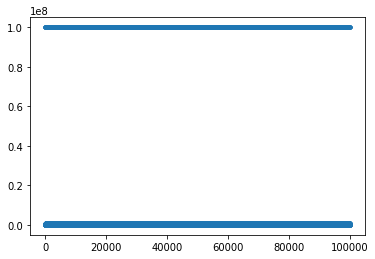

In [0]:
plt.plot(df_train["Current Loan Amount"], ".") # посмотрим распределние данных "Current Loan Amount", картина свидетельствует 
pass                                           # о выбросах в высоких значениях

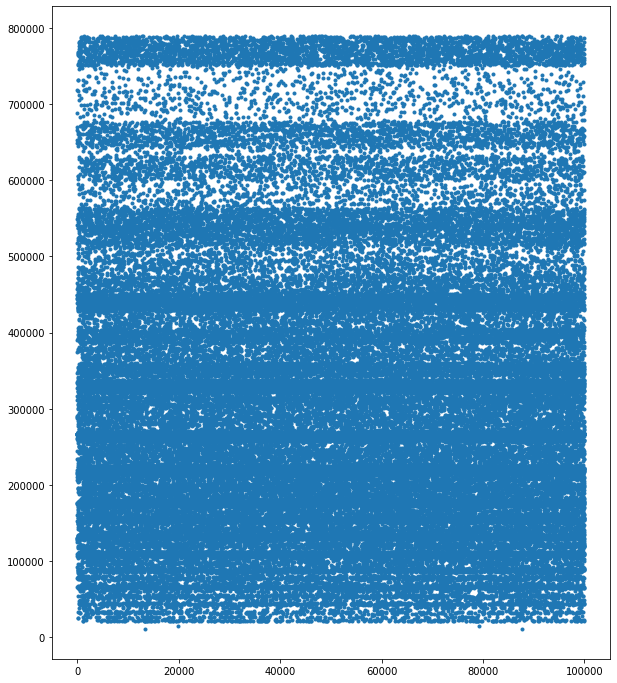

In [0]:
df_train["Current Loan Amount"].max() # найдем эти выбросы
# df_train = df_train[df_train["Current Loan Amount"] == 99999999.0]["Current Loan Amount"]
df_train = df_train.replace({'Current Loan Amount': {99999999.0: df_train[df_train["Current Loan Amount"] != 99999999.0]["Current Loan Amount"].median()}})
plt.figure(figsize=(10,12))
plt.plot(df_train["Current Loan Amount"], ".")
pass

In [0]:
df_train.shape

(100000, 17)

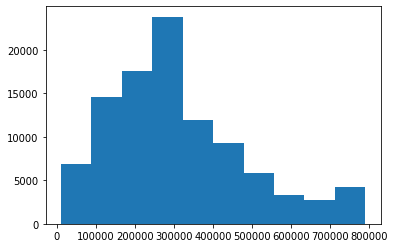

In [0]:
plt.hist(df_train["Current Loan Amount"]) # пик в центре вырос из за заполнения выбросов медианой
pass

Гистограмма "Current Loan Amount" признака выглядит адекватно, очевидных выбросов больше не наблюдается.

Рассмотрим количество пропущенных данных в признаках

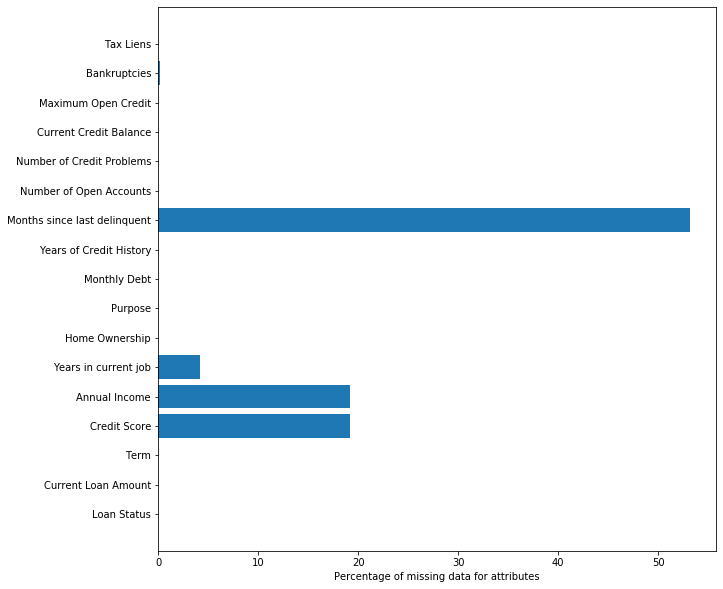

In [0]:
plt.figure(figsize=(10,10))
plt.barh(df_train.columns, (df_train.isnull().sum()/len(df_train))*100)
plt.xlabel("Percentage of missing data for attributes")
pass

Для признака "Months since last delinquent" пропущено более 50% данных, исключим его из набора данных. Остальные признаки попробуем заполнить медианой после первичного анализа

In [0]:
df_train = df_train.drop(["Months since last delinquent"], axis = 1)
df_train

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0
1,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,35.0,0.0,229976.0,850784.0,0.0,0.0
2,Fully Paid,267344.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0
3,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0
4,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,15.0,0.0,253460.0,427174.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Fully Paid,147070.0,Short Term,725.0,475437.0,7 years,Own Home,other,2202.86,22.3,5.0,0.0,47766.0,658548.0,0.0,0.0
99996,Fully Paid,267344.0,Short Term,732.0,1289416.0,1 year,Rent,Debt Consolidation,13109.05,9.4,22.0,0.0,153045.0,509234.0,0.0,0.0
99997,Fully Paid,103136.0,Short Term,742.0,1150545.0,6 years,Rent,Debt Consolidation,7315.57,18.8,12.0,1.0,109554.0,537548.0,1.0,0.0
99998,Fully Paid,530332.0,Short Term,746.0,1717524.0,9 years,Rent,Debt Consolidation,9890.07,15.0,8.0,0.0,404225.0,738254.0,0.0,0.0


Рассмотрим следующие признаки

Short Term - 72.208000 %
Long Term - 27.792000 %


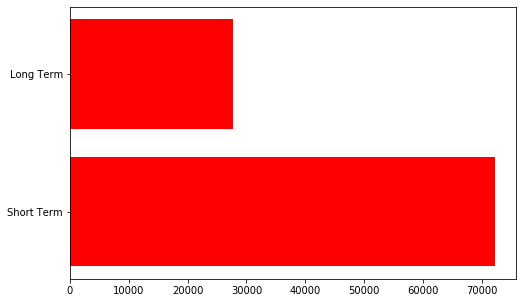

In [0]:
plot_hist_categorial_attribute(df_train, "Term")

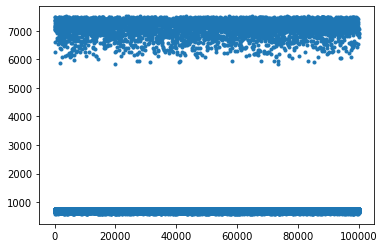

In [0]:
plt.plot(df_train["Credit Score"], ".") # посмотрим распределние данных "Credit Score" 
pass

Разделение признака на два непересекающихся кластера, странная ситуация, рассмотрим подробнее

4551


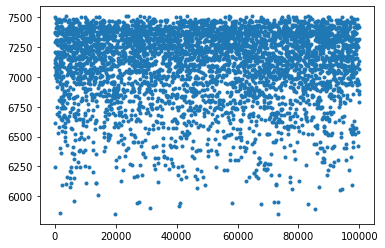

In [0]:
Credit_Score = df_train["Credit Score"][df_train["Credit Score"]>2000 ]
print(len(Credit_Score))
plt.plot(Credit_Score, ".") 
pass

76295


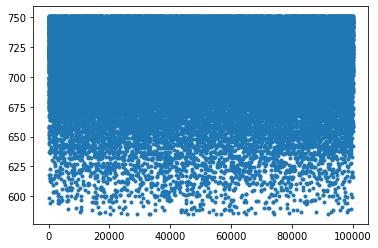

In [0]:
Credit_Score = df_train["Credit Score"][df_train["Credit Score"]<2000 ]
print(len(Credit_Score))
plt.plot(Credit_Score, ".") 
pass

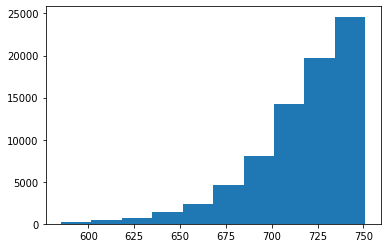

In [0]:
plt.hist(Credit_Score) 
pass

Разобъем данные на 2 кластера

In [0]:
df_train2 = df_train[df_train["Credit Score"].isnull()]
df_train3 = df_train[df_train["Credit Score"]<2000 ]
lower = df_train3.append(df_train2)
lower["Credit Score"] = lower["Credit Score"].fillna(lower["Credit Score"].median()) # заполним пропуски медианой

Charged Off - 100.000000 %


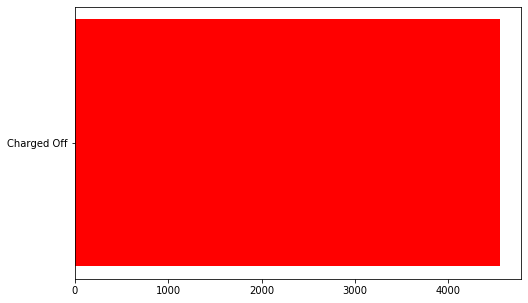

In [0]:
upper = df_train[df_train["Credit Score"]>2000]
plot_hist_categorial_attribute(upper, "Loan Status")

Все объекты для которых "Credit Score" > 2000 принадлежат к классу "Charged Off". В итоговой модели, следует это использовать.

Charged Off - 18.950434 %
Fully Paid - 81.049566 %


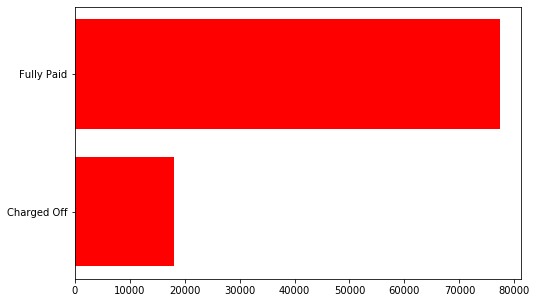

In [0]:
plot_hist_categorial_attribute(lower, "Loan Status")

In [0]:
df_train = copy.deepcopy(lower)


Поискав в интернете информацию про "Credit Score" находим возможную интерпретацию значений данного признака. Для кластера lower эта интерпретация вполне совпадает.

In [0]:
from IPython.core.display import HTML 
from IPython.display import Image
Image(url= "https://www.experian.com/blogs/ask-experian/wp-content/img/experian-good-score-ranges-fico.png")

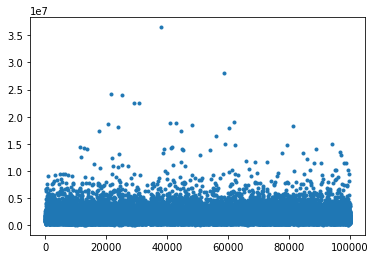

In [0]:
plt.plot(df_train["Annual Income"], ".") # на графике видим выбросы
pass

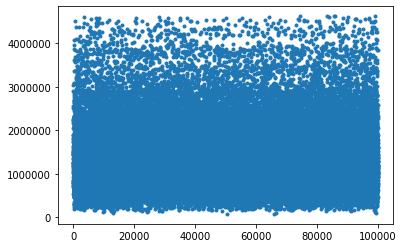

In [0]:
plt.plot(df_train["Annual Income"][df_train["Annual Income"]<df_train['Annual Income'].quantile(0.99)], ".") # уберем их с помощью квантилей
# print(len(df_train["Annual Income"][df_train["Annual Income"]<df_train['Annual Income'].quantile(0.99)]))
pass

In [0]:
df_train.shape

(95449, 16)

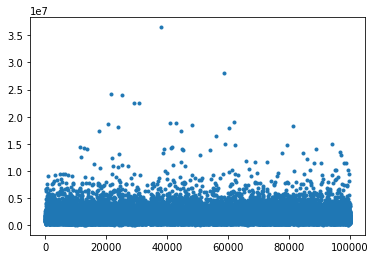

In [0]:
plt.plot(df_train["Annual Income"], ".")
pass

(95386, 16)

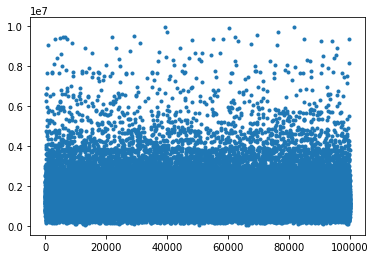

In [0]:
plt.plot(df_train[df_train["Annual Income"]<0.01*10**9]["Annual Income"], ".")

df_train2 = df_train[df_train["Annual Income"].isnull()]
df_train3 = df_train[df_train["Annual Income"]<0.01*10**9 ]
df_train4 = df_train3.append(df_train2)
df_train4["Annual Income"] = df_train4["Annual Income"].fillna(df_train4["Annual Income"].median()) # заполним пропуски медианой
df_train = copy.deepcopy(df_train4)
df_train.shape

# df_train = df_train[df_train["Annual Income"]<0.02*10**8]
# df_train = df_train[df_train["Annual Income"]<0.01*10**9]
# df_train.shape


Рассмотрим распределение "Years in current job" без пропущенных значений

4 years - 6.448966 %
10+ years - 32.533640 %
6 years - 5.914014 %
7 years - 5.786019 %
< 1 year - 8.527513 %
1 year - 6.700580 %
8 years - 4.788316 %
3 years - 8.522044 %
9 years - 4.124275 %
5 years - 7.104256 %
2 years - 9.550377 %


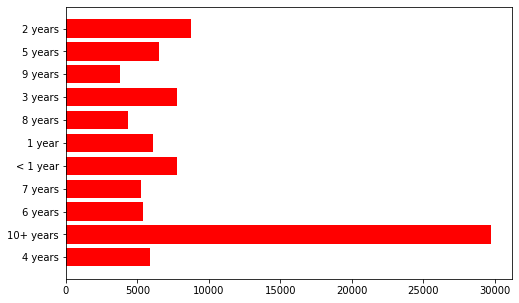

In [0]:
plot_hist_categorial_attribute(df_train.dropna(subset=["Years in current job"]), "Years in current job")

Распределение выглядит адекватно, заменим пропуски модой

In [0]:
tmp = {"Years in current job":"10+ years"}
df_train = df_train.fillna(tmp)

Рассмотрим признак "Home Ownership"

Own Home - 9.161722 %
Rent - 42.008261 %
HaveMortgage - 0.217013 %
Home Mortgage - 48.613004 %


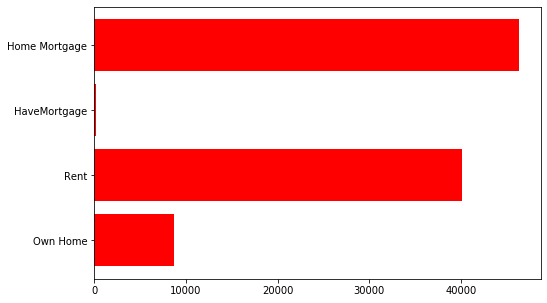

In [0]:
plot_hist_categorial_attribute(df_train, "Home Ownership")

Из графика видно что "HaveMortgage" встречается очень редко, лишь в 0.22% и по смыслу совпадает с "Home Mortgage". Приведем их к одному значению

In [0]:
df_train = df_train.replace({'Home Ownership': {"HaveMortgage": "Home Mortgage"}})

moving - 0.146772 %
Buy House - 0.676200 %
small_business - 0.274673 %
vacation - 0.100644 %
Other - 3.287694 %
Medical Bills - 1.121758 %
Educational Expenses - 0.100644 %
Home Improvements - 5.881366 %
other - 6.056444 %
Buy a Car - 1.275869 %
Take a Trip - 0.575556 %
wedding - 0.119514 %
renewable_energy - 0.009435 %
Business Loan - 1.548445 %
major_purchase - 0.347011 %
Debt Consolidation - 78.477974 %


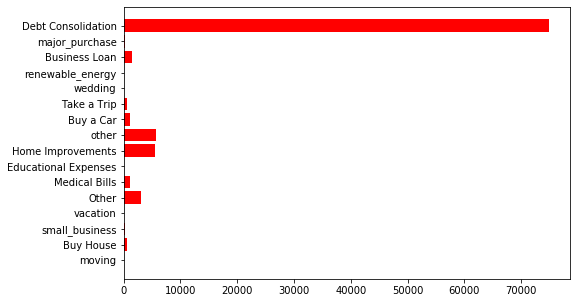

In [0]:
plot_hist_categorial_attribute(df_train, "Purpose")

Преобладает значение 'Debt Consolidation'. Заменим "other": "Other" и "Take a Trip": "vacation" чтобы уменьшить число возможных значений, т.ек препологаем что по смыслу это одно и то же

In [0]:
df_train = df_train.replace({'Purpose': {"other": "Other"}})
df_train = df_train.replace({'Purpose': {"Take a Trip": "vacation"}})

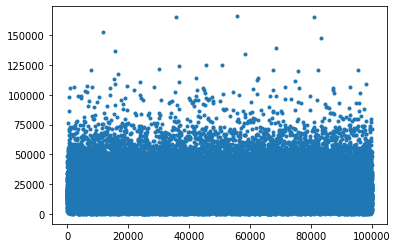

In [0]:
plt.plot(df_train["Monthly Debt"], ".")
pass

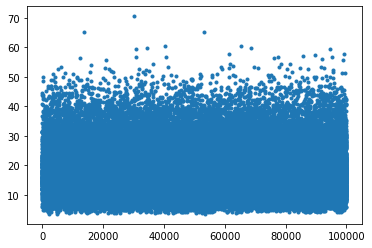

In [0]:
plt.plot(df_train["Years of Credit History"], ".")
pass

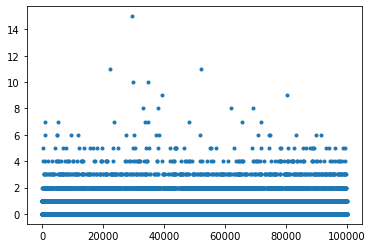

In [0]:
plt.plot(df_train["Number of Credit Problems"], ".")
pass

Явных выбросов не наблюдаем

Очистим последние признаки от выбросов и пустых значений

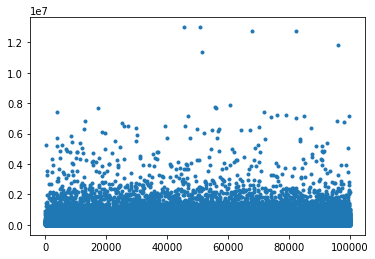

In [0]:
plt.plot(df_train["Current Credit Balance"], '.')
pass

In [0]:
df_train = df_train[df_train["Current Credit Balance"]<1*10**7] 
df_train.shape

(95380, 16)

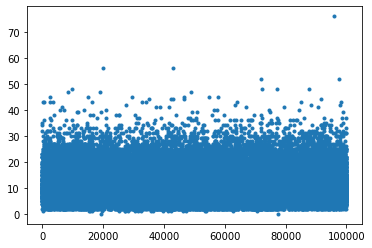

In [0]:
plt.plot(df_train["Number of Open Accounts"], ".")
pass

In [0]:
df_train = df_train[df_train["Number of Open Accounts"] < 60]


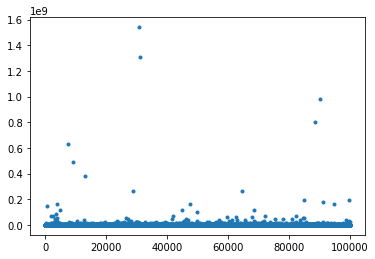

In [0]:
plt.plot(df_train["Maximum Open Credit"], '.')
pass

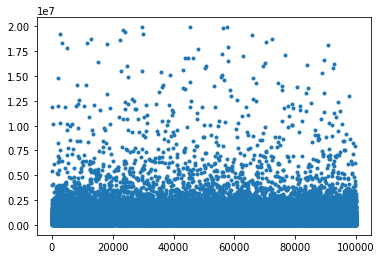

In [0]:
 plt.plot(df_train[df_train["Maximum Open Credit"] < 0.02*10**9]["Maximum Open Credit"], ".")
 pass


In [0]:
df_train = df_train[df_train["Maximum Open Credit"] < 0.02*10**9]

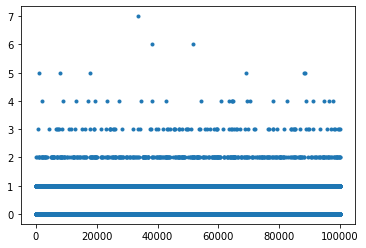

In [0]:
plt.plot(df_train["Bankruptcies"], ".") #Tax Liens
pass

Предпологается, что признак "Bankruptcies" бинарный, поэтому уберем все данные выше 1

In [0]:
print(len(df_train[df_train["Bankruptcies"]>=2]))
df_train = df_train[df_train["Bankruptcies"]<2]
df_train.shape

527


(94582, 16)

Ан-но ситуация с признаком "Tax Liens"

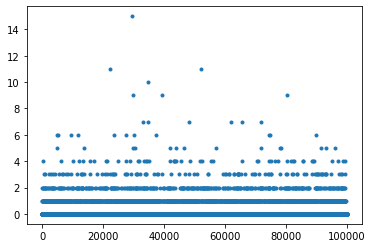

In [0]:
plt.plot(df_train["Tax Liens"], ".")
pass

In [0]:
print(len(df_train[df_train["Tax Liens"]>=2]))
df_train = df_train[df_train["Tax Liens"]<2]
df_train.shape


530


(94052, 16)

проверяем, избавились ли от всех пропущенных значений

In [0]:
df_train.isnull().sum()

Loan Status                  0
Current Loan Amount          0
Term                         0
Credit Score                 0
Annual Income                0
Years in current job         0
Home Ownership               0
Purpose                      0
Monthly Debt                 0
Years of Credit History      0
Number of Open Accounts      0
Number of Credit Problems    0
Current Credit Balance       0
Maximum Open Credit          0
Bankruptcies                 0
Tax Liens                    0
dtype: int64

Векторизуем категориальные признаки

In [0]:
df_train_copy = copy.deepcopy(df_train)

In [0]:
categorical_columns = [c for c in df_train.columns if df_train[c].dtype.name == 'object']
numerical_columns   = [c for c in df_train.columns if df_train[c].dtype.name != 'object']

In [0]:
data_describe = df_train.describe(include = [object])
for c in categorical_columns:
    df_train[c] = df_train[c].fillna(data_describe[c]['top'])

In [0]:
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

['Loan Status', 'Term'] ['Years in current job', 'Home Ownership', 'Purpose']


In [0]:
for binary in binary_columns:
  elements =  df_train[binary].unique()
  number = 0.0
  for i in elements:
    df_train.at[df_train[binary] == i, binary] = number
    number = number + 1.0

In [0]:
for nonbinary in nonbinary_columns:
  elements =  df_train[nonbinary].unique()
  number = 0.0
  for i in elements:
    df_train.at[df_train[nonbinary] == i, nonbinary] = number
    number = number + 1.0

In [0]:
df_train

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,0,445412.0,0,709.0,1167493.0,0,0,0,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0
2,0,267344.0,0,741.0,2231892.0,0,1,1,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0
3,0,347666.0,1,721.0,806949.0,1,1,1,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0
6,0,217646.0,0,730.0,1184194.0,2,0,1,10855.08,19.6,13.0,1.0,122170.0,272052.0,1.0,0.0
8,0,548746.0,0,678.0,2559110.0,3,2,1,18660.28,22.6,4.0,0.0,437171.0,555038.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99978,0,431860.0,1,722.0,1183073.0,5,0,1,8465.07,18.5,5.0,0.0,241319.0,476806.0,0.0,0.0
99982,0,484968.0,1,722.0,1183073.0,5,0,1,20941.80,23.7,15.0,0.0,804175.0,1322662.0,0.0,0.0
99988,1,309474.0,0,722.0,1183073.0,5,0,1,13817.18,26.9,15.0,0.0,225872.0,892606.0,0.0,0.0
99989,1,429132.0,0,722.0,1183073.0,5,0,1,28948.02,16.3,16.0,0.0,485279.0,656414.0,0.0,0.0


Рассмотрим матрицу корреляции

In [0]:
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
Loan Status,1,0.0487339,0.103255,-0.0753676,-0.0707085,0.00670117,0.0506708,0.00511482,0.00803406,-0.0212692,0.0101728,-0.000226234,-0.00909424,-0.0364755,-0.00503308,0.00466579
Current Loan Amount,0.0487339,1,0.405886,-0.190187,0.376352,0.026001,-0.183033,-0.17598,0.412479,0.146585,0.18882,-0.0893133,0.337503,0.254781,-0.0943693,0.0114978
Term,0.103255,0.405886,1,-0.419666,0.107218,0.0198253,-0.116578,-0.0628464,0.159121,0.0416334,0.0821849,-0.0272641,0.115162,0.0737074,-0.0263534,-0.00405297
Credit Score,-0.0753676,-0.190187,-0.419666,1,-0.01445,-0.00677977,-0.038697,-0.0626963,-0.0821665,0.0703671,-0.0266575,-0.042375,-0.0173849,0.0792027,-0.0302192,-0.0146937
Annual Income,-0.0707085,0.376352,0.107218,-0.01445,1,0.0142835,-0.19929,-0.0269519,0.534463,0.184439,0.168391,-0.0428991,0.344087,0.272409,-0.0556729,0.0301178
Years in current job,0.00670117,0.026001,0.0198253,-0.00677977,0.0142835,1,-0.0665933,-0.0220048,0.036057,0.0455981,0.0184658,0.0147396,0.0279197,0.0161897,0.0153933,0.00598475
Home Ownership,0.0506708,-0.183033,-0.116578,-0.038697,-0.19929,-0.0665933,1,0.0953263,-0.208031,-0.199403,-0.137434,-0.00837357,-0.181344,-0.164884,-0.00462968,-0.00686534
Purpose,0.00511482,-0.17598,-0.0628464,-0.0626963,-0.0269519,-0.0220048,0.0953263,1,-0.0859547,-0.0272431,-0.0904321,-0.0139744,-0.0769503,-0.0384079,-0.0196427,-0.000447075
Monthly Debt,0.00803406,0.412479,0.159121,-0.0821665,0.534463,0.036057,-0.208031,-0.0859547,1,0.202512,0.417074,-0.0739642,0.496692,0.321657,-0.0821137,0.0167315
Years of Credit History,-0.0212692,0.146585,0.0416334,0.0703671,0.184439,0.0455981,-0.199403,-0.0272431,0.202512,1,0.133497,0.0699162,0.225729,0.209728,0.0736513,0.0141864


С целевым признаком другие признаки практически не корреляруют, нет коэф. корреляции который был бы по абсолютному значению больше 0.11. Сильная корреляция (>0.85) отсутсвует. Самая сильная корреляция для Банкротов с количеством проблем с кредитами, корреляция вполне очевидна. Корреляция Current Credit Balance и Maximum Open Credit подтверждает мои преположения о интерпретации данных признаков. Monthly Debt коррелирует с Annual Income и Current Loan Amount, чем больше зарплата тем более большие кредиты берут люди и им нужно больше платить ежемесячно.

Обработаем категориальные не бинарные признаки используя dummy переменные

In [0]:
data_nonbinary = pd.get_dummies(df_train_copy[nonbinary_columns])

In [0]:

for binary in binary_columns:
  elements =  df_train_copy[binary].unique()
  number = 0.0
  for i in elements:
    df_train_copy.at[df_train_copy[binary] == i, binary] = number
    number = number + 1.0

Нормализуем числовые признаки, чтобы они вносили один вклад в итоговую модель, т.к. данные отличаются на порядки

In [0]:
data_numerical = df_train_copy[numerical_columns]

In [0]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)

In [0]:
data = pd.concat((data_numerical, data_nonbinary, df_train_copy[binary_columns]), axis = 1)
print(data.shape)

(94052, 41)


In [0]:
data

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_Business Loan,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_major_purchase,Purpose_moving,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding,Loan Status,Term
0,0.795248,-0.346281,-0.224637,-1.106245,-0.141229,-1.024475,2.280922,-0.192353,-0.284364,2.913358,-0.115492,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,-0.222213,0.922629,1.231962,0.899866,-0.469323,1.376156,2.280922,0.016758,0.113453,-0.343243,-0.115492,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0.236738,0.129560,-0.718031,-0.811243,-0.883006,-0.424317,-0.370452,-0.108060,-0.319913,-0.343243,-0.115492,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
6,-0.506182,0.486441,-0.201782,-0.634502,0.201129,0.375893,2.280922,-0.509948,-0.457043,2.913358,-0.115492,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8,1.385687,-1.575536,1.679751,0.018306,0.629077,-1.424580,-0.370452,0.433673,-0.119324,-0.343243,-0.115492,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99978,0.717813,0.169214,-0.203316,-0.834396,0.044215,-1.224528,-0.370452,-0.153024,-0.212687,-0.343243,-0.115492,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
99982,1.021266,0.169214,-0.203316,0.209126,0.785992,0.775998,-0.370452,1.533074,0.796767,-0.343243,-0.115492,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
99988,0.018513,0.169214,-0.203316,-0.386759,1.242470,0.775998,-0.370452,-0.199297,0.283533,-0.343243,-0.115492,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
99989,0.702225,0.169214,-0.203316,0.878746,-0.269614,0.976051,-0.370452,0.577786,0.001659,-0.343243,-0.115492,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [0]:
data.to_csv("drive/colab/Zolotich/processed_credit_train.csv")

Подготовим данные для модели

In [0]:
X = data.drop('Loan Status', axis = 1) # выбрасываем столбец Loan Status
y = data['Loan Status']
feature_names = X.columns

In [0]:
feature_names

Index(['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt',
       'Years of Credit History', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens',
       'Years in current job_1 year', 'Years in current job_10+ years',
       'Years in current job_2 years', 'Years in current job_3 years',
       'Years in current job_4 years', 'Years in current job_5 years',
       'Years in current job_6 years', 'Years in current job_7 years',
       'Years in current job_8 years', 'Years in current job_9 years',
       'Years in current job_< 1 year', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent',
       'Purpose_Business Loan', 'Purpose_Buy House', 'Purpose_Buy a Car',
       'Purpose_Debt Consolidation', 'Purpose_Educational Expenses',
       'Purpose_Home Improvements', 'Purpose_Medical Bills', 'Purpose_Other',
       'Purpose_major_purchase', 

отдельно будем хранить данные, для которых Credit Score >2000, т.е. для них точность предсказания у нас будет равна 100%, добавим эти данные в конце к итоговым метрикам. Я не стал использовать эти данные для обучения, т.к. это может вызвать переобучение, и я уже могу с веротностью 100% предсказывать ответ по этому признаку по конкретному порогу

In [0]:
upper_test = int(len(upper)/100*30)
upper_train = len(upper) - upper_test
upper_train

3186

подготовим данные для обучения

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)



In [0]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [0]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.19272753047916075

In [0]:
err_test  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)]))) # добавим предикт полученный по жесткому правилу в начале

In [0]:
err_test


0.18383421791014504

In [0]:
added_accuracy = 0.19272753047916075 - 0.18383421791014504

In [0]:
%matplotlib inline

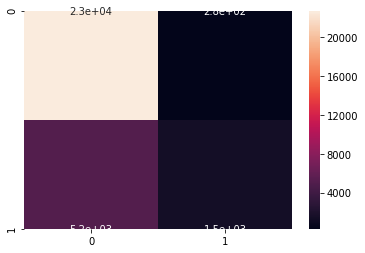

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predict)
cm[1,1] = cm[1,1] + upper_test # добавим данные полученные разделением Credit_Score
sns.heatmap(cm, annot=True)

In [0]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.1904125402515341 55


In [0]:
print(best_cv_err-added_accuracy)

0.18151922768251838


In [0]:
data_s1 = data[data["Loan Status"] == 0].sample(n=len(data[data["Loan Status"] == 1])) # Попробуем сбаланировать выборку, уменьшая ее размерность
data_s2 = data[data["Loan Status"] == 1]
data_s = data_s1.append(data_s2)

In [0]:
X = data_s.drop('Loan Status', axis = 1) # выбрасываем столбец Loan Status
y = data_s['Loan Status']


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)



In [0]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [0]:
y_test_predict = knn.predict(X_test)

err_test  = np.mean(y_test  != y_test_predict)
err_test

0.4400561534861956

In [0]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))

In [0]:
err_test


0.39020746887966806

In [0]:
added_accuracy = 0.44838558727187644 - 0.39759336099585063

In [0]:
cm

array([[22664,   275],
       [ 5163,  1479]])

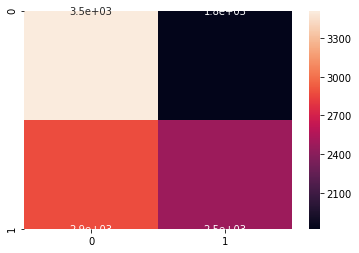

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predict)
sns.heatmap(cm, annot=True)

In [0]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.42019975131362564 55


In [0]:
print(best_cv_err-added_accuracy)

0.3694075250375998


Уменьшение обучающей выборки значительно ухудшает результат


# Лабораторная: использование PCA



In [0]:
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Попробуем применить другие классификаторы, без использования подбора параметров

In [0]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(decomposed_train_X, y_train)
y_test_predict = dt_classifier.predict(decomposed_test_X)
err_test_dt  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))
print(f"DT error test - {err_test_dt}")

svm = SVC(gamma='auto')
svm.fit(decomposed_train_X, y_train)
y_test_predict = svm.predict(decomposed_test_X)
err_test_svm  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))
print(f"SVM error test - {err_test_svm}")

rfc = RandomForestClassifier(n_estimators=100, max_depth=2,
                              random_state=0)
rfc.fit(decomposed_train_X, y_train) 
y_test_predict = rfc.predict(decomposed_test_X)
err_test_rf  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))
print(f"RF error test - {err_test_rf}")


DT error test - 0.25482573273384945
SVM error test - 0.17839153510699435
RF error test - 0.17839153510699435


Результаты превосходят предыдущий лучший классификатор по KNN с подбором параметров

Применим PCA

In [0]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=2, random_state=42) # возьмем первые 2 компоненты


In [0]:
X = data.drop('Loan Status', axis = 1) 
y = data['Loan Status']
feature_names = X.columns

In [0]:
decomposed_data_X = pca.fit_transform(X)
decomposed_train_X, decomposed_test_X, y_train, y_test = train_test_split(decomposed_data_X, y, test_size = 0.3, random_state = 42)

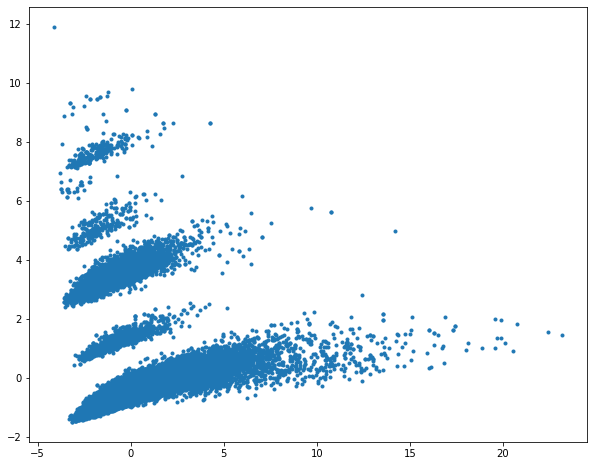

In [0]:
plt.figure(figsize=(10,8))
plt.plot(decomposed_data_X[:,0], decomposed_data_X[:,1], '.') 
plt.show()

Графическое представление данных в двумерном пространстве. Данные неплохо кластеризировались, возможно, использование этого преобразование улучшит результат.

In [0]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 55)
knn.fit(decomposed_train_X, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=55, p=2,
                     weights='uniform')

In [0]:
y_test_predict = knn.predict(decomposed_test_X)

err_test  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))
err_test

0.17842534059024373

Ошибка уменьшилась, используя лучший классификатор с прошлого раза. Имеет смысл применять данную обработку данных, используя другие классификаторы.

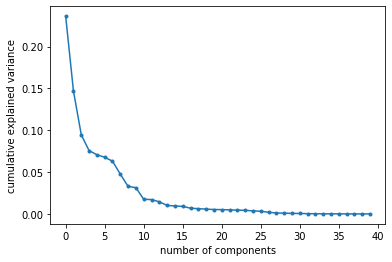

In [0]:
pca = PCA().fit(X)
plt.plot(pca.explained_variance_ratio_, '.-')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


Попробуем использовать количество компонент, для которых на графике cumulative explained variance присутсвуют скачки - 1, 2, 4, 9, 11

In [0]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

test_errors = list()

for i in [1, 2, 4, 9, 11]:
  pca = PCA(n_components=i, random_state=42)
  decomposed_data_X = pca.fit_transform(X)
  decomposed_train_X, decomposed_test_X, y_train, y_test = train_test_split(decomposed_data_X, y, test_size = 0.3, random_state = 42)

  knn = KNeighborsClassifier(n_neighbors = 55)
  knn.fit(decomposed_train_X, y_train)
  y_test_predict = knn.predict(decomposed_test_X)
  err_test_knn  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))

  dt_classifier = DecisionTreeClassifier()
  dt_classifier.fit(decomposed_train_X, y_train)
  y_test_predict = dt_classifier.predict(decomposed_test_X)
  err_test_dt  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))

  svm = SVC(gamma='auto')
  svm.fit(decomposed_train_X, y_train)
  y_test_predict = svm.predict(decomposed_test_X)
  err_test_svm  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))

  rfc = RandomForestClassifier(n_estimators=100, max_depth=2,
                               random_state=0)
  rfc.fit(decomposed_train_X, y_train) 
  y_test_predict = rfc.predict(decomposed_test_X)
  err_test_rf  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))

  test_errors.append({"Num_components":i,
                      "Knn_test_errors":err_test_knn,
                      "SVM_test_errors":err_test_svm,
                      "DT_test_errors":err_test_dt,
                      "RF_test_errors":err_test_rf})
  
  print(i, err_test_knn, err_test_svm, err_test_dt, err_test_rf)


In [0]:
components = [i["Num_components"] for i in test_errors]  
err_test_knn = [i["Knn_test_errors"] for i in test_errors]  
err_test_svm = [i["SVM_test_errors"] for i in test_errors]  
err_test_dt = [i["DT_test_errors"] for i in test_errors]  
err_test_rf = [i["RF_test_errors"] for i in test_errors]  

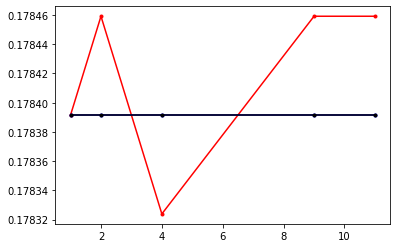

In [0]:
plt.plot(components, err_test_knn, '.-', color = "red")
plt.plot(components, err_test_svm, '.-', color = "blue") 
# plt.plot(components, err_test_dt, '.', color = "pink")  # Значительно хуже остальных, ~0.27 errors
plt.plot(components, err_test_rf, '.-', color = "black") 


KNN рабоатет лучше при использовании PCA. Меньшая ошибка достигается при использовании 4 главных компонент. Остальные методы работают хуже чем KNN, метод PCA не дает улучшений для остальных алгоритмов.

# Лабораторная работа: использование нейронных сетей

In [0]:
import torch
from sklearn.model_selection import train_test_split


In [0]:
data = pd.read_csv("drive/colab/Zolotich/processed_credit_train.csv")

In [0]:
X = data.drop('Loan Status', axis = 1) 
y = data['Loan Status']
feature_names = X.columns
print(X.shape)

(94052, 41)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

Разобьем данные на тренировочный, тестовый и валидационный наборы

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Проверем подключена ли видеокарта к ноутбуку, установлены ли драйверы и CUDA

Определим класс Dataset

In [0]:
class Dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y.to_numpy()

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)


Определим класс FcNet - ахитектуру нашей нейронной сети. Будем использовать 2-х слойную полносвязную нейронную сеть, в качестве функции активации возьмем ReLU, добавим между слоями батч нормализацию и дропаут. Наш набор данных небольшой и полностью влезает в батч на текущей видеокарточке. 

In [0]:
import torch.nn as nn


class FcNet(nn.Module):
    def __init__(self, num_classes, input_size, layer_size_1, layer_size_2, dropout_1, dropout_2):
        super(FcNet, self).__init__()
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.batch_norm_1 = nn.BatchNorm1d(layer_size_1)
        self.batch_norm_2 = nn.BatchNorm1d(layer_size_2)
        self.relu = nn.ReLU(True)
        self.dropout_1 = nn.Dropout(p=dropout_1)
        self.dropout_2 = nn.Dropout(p=dropout_2)
        self.fc_0 = nn.Linear(input_size, layer_size_1)
        self.fc_1 = nn.Linear(layer_size_1, layer_size_2)
        self.fc_2 = nn.Linear(layer_size_2, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_weights(self):
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)

    def forward(self, batch_input):
        out = self.batch_norm(batch_input)
        out = self.fc_0(out)
        out = self.batch_norm_1(out)
        out = self.relu(out)
        out = self.dropout_1(out)

        out = self.fc_1(out)
        out = self.batch_norm_2(out)
        out = self.relu(out)
        out = self.dropout_2(out)

        # print(out.shape)
        out = self.fc_2(out)
        # out = self.batch_norm_3(out)
        out = self.softmax(out)
        return out


Построим общий пайплайн который будем исопльзовать в дальнейшем. 

In [0]:
def train_test_val(model, 
                   dataloaders, 
                   optimizer,
                   learning_rate,
                   limit_not_progress = 5, # максимальное количество эпох без улучшения лосс функции на тестовом наборе, после этого останавливаем обучение
                   best_val_loss = 1000,
                   nb_classes = 2, 
                   num_epochs = 30, # для быстроты проведения экспериментов, уменьшим количество эпох, в реальной задаче, обучали бы до наступления early stopping
                   criterion = nn.CrossEntropyLoss(),
                   criterion_text = "CrossEntropyLoss",
                   batch_size = 100000):
  early_stoping = False
  not_progress = 0
  dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', "test"]}
  for epoch in range(num_epochs):

    if early_stoping:
        model.load_state_dict(best_model_wts)
        result_model = copy.deepcopy(model)
        break

    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # each epoch has a training and validation phase
    for phase in ['train', 'val', "test"]:
        confusion_matrix = {x: torch.zeros(nb_classes, nb_classes) for x in ["total", 'train', 'val', "test"]} 

        print(phase)
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        epoch_pred = []

        # iterate over data

        for (inputs, labels) in dataloaders[phase]:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            if phase == 'val' or phase == "test":
                optimizer.zero_grad()
            outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)

            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[phase][t.long(), p.long()] += 1

            with torch.set_grad_enabled(phase == 'train'):
                loss = criterion(outputs, labels)

                if phase == 'train':
                    if criterion_text == "MSELoss":
                        loss = torch.autograd.Variable(loss, requires_grad = True)
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
            epoch_pred = epoch_pred+preds.tolist()
            running_corrects += torch.sum(preds == labels.data)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.item() / dataset_sizes[phase]

        print('{}\tLoss: {:.4f}\t'.format(
            phase, epoch_loss))

        print('{}\tAccuracy: {:.4f}\t'.format(
            phase, epoch_acc))
        print("Conf matrix " + phase)

        print(confusion_matrix[phase])
    
        if phase == 'val' and epoch_loss < best_val_loss:
            print("decrease loss ")
            best_val_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            current_wts = copy.deepcopy(model.state_dict())
            model.load_state_dict(best_model_wts)
            result_model = copy.deepcopy(model)
            model.load_state_dict(current_wts)
            not_progress = 0
        elif phase == "val":
            print("not decrease loss", not_progress)
            not_progress = not_progress + 1
            if limit_not_progress < not_progress:
                early_stoping = True

        print(best_val_loss)
    print()
  return result_model

In [0]:
def f1_loss(conf_matrix):
  conf_matrix = conf_matrix['test']
  precision = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
  recall = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0])
  f1_score = 2 * precision * recall / (precision + recall)
  return f1_score

In [0]:
def predict_classificators(classifier, datasets):
  answer_loss = []
  answer_acc = []
  keys = []
  answer_f1 = []
  answer_matrix = []
  dataset_sizes = {x: len(datasets[x]) for x in ['test']}
  phase = "test"
  criterion = nn.CrossEntropyLoss()
  nb_classes = 2
  keys.append(classifier)
  running_loss = 0.0
  running_corrects = 0
  confusion_matrix = {x: torch.zeros(nb_classes, nb_classes) for x in ['test']} 

  for (inputs, labels) in dataloaders['test']:
    inputs = inputs.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)

    outputs = classifier(inputs)

    with torch.set_grad_enabled(phase == 'train'):
      loss = criterion(outputs, labels)

    _, preds = torch.max(outputs.data, 1)

    for t, p in zip(labels.view(-1), preds.view(-1)):
      confusion_matrix[phase][t.long(), p.long()] += 1

  
    running_corrects += torch.sum(preds == labels.data)
    running_loss += loss.item() * inputs.size(0)
    f1_score = f1_loss(confusion_matrix)
    epoch_loss = running_loss / dataset_sizes['test']
    epoch_acc = running_corrects.item() / dataset_sizes['test']
    answer_acc.append(epoch_acc)
    answer_loss.append(epoch_loss)
    answer_f1.append(f1_score)
    answer_matrix.append(confusion_matrix['test'])
  return answer_acc, answer_loss, answer_f1, answer_matrix, keys

In [0]:
model = FcNet(2, X.shape[1], 400, 400, 0.2, 0.2)
model = model.to(device)
model = model.double()
learning_rate = 0.001
batch_size = 100000
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0)

datasets = {
        'train': Dataset(x=X_train, y=y_train),
        'test':  Dataset(x=X_test, y=y_test),
        'val': Dataset(x=X_val, y=y_val)
    }

dataloaders = {
        x: torch.utils.data.DataLoader(
            datasets[x], batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
        for x in ['train', 'val', "test"]
    }

FcNet_400_400_02_02 = train_test_val(model,dataloaders,optimizer, learning_rate)

Значение loss немного уменьшается при обучение, однако классификатор практически сразу сваливается в константный классификатор. Точность модели не меняется из за этого, изменение loss связано с тем, что в качестве лосс функции была выбрана кросс энтропия и модель изменяя вероятности принадлажания объекта к классу уменьшает lossы. 

Попробуем потюнить модель, изменив значение дропаутов, размерности слоев.

In [0]:
first_layer_set = [10, 50, 100, 400]
second_layer_set = [10, 50, 100, 400]
dropout_set = [0, 0.2, 0.5, 0.8]
result = dict()
batch_size = 100000
datasets = {
        'train': Dataset(x=X_train, y=y_train),
        'test':  Dataset(x=X_test, y=y_test),
        'val': Dataset(x=X_val, y=y_val)
    }

dataloaders = {
        x: torch.utils.data.DataLoader(
            datasets[x], batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
        for x in ['train', 'val', "test"]
    }

for first_layer in first_layer_set:
  for second_layer in second_layer_set:
    for dropout in dropout_set:

      model = FcNet(2, X.shape[1], first_layer, second_layer, dropout, dropout)
      model = model.to(device)
      model = model.double()
      learning_rate = 0.001
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)

      result["FcNet_"+str(first_layer)+"_"+str(second_layer)+"_"+str(dropout)]  = train_test_val(model,dataloaders,optimizer, learning_rate)

      

In [0]:
answer_acc, answer_loss, answer_f1, answer_matrix, keys = predict_classificators(result, datasets)

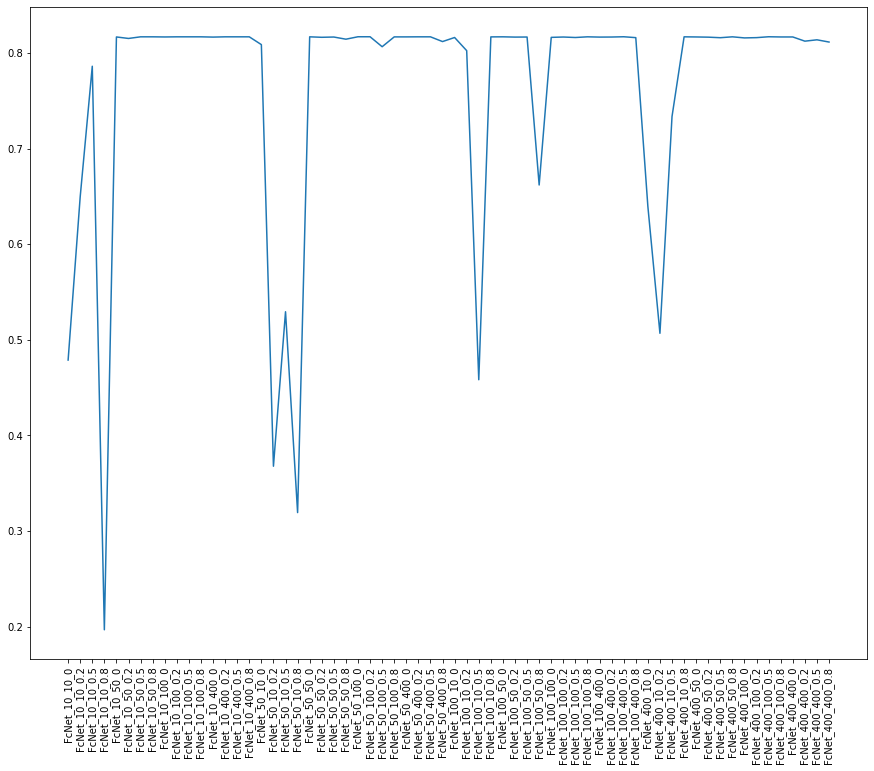

In [0]:
plt.figure(figsize=(15,12))
plt.xticks(rotation=90)
plt.plot(keys, answer_acc)

В процессе обучения, обращаем внимание на матрицу ошибок. Наблюдаем переобучение классификатора в константный классификатор, поэтому проанализируем F1 метрику для проверки, есть ли здесь не константный классификатор.

In [0]:
answer_tp = [i[0][0] for i in answer_matrix]
answer_tn = [i[1][1] for i in answer_matrix]

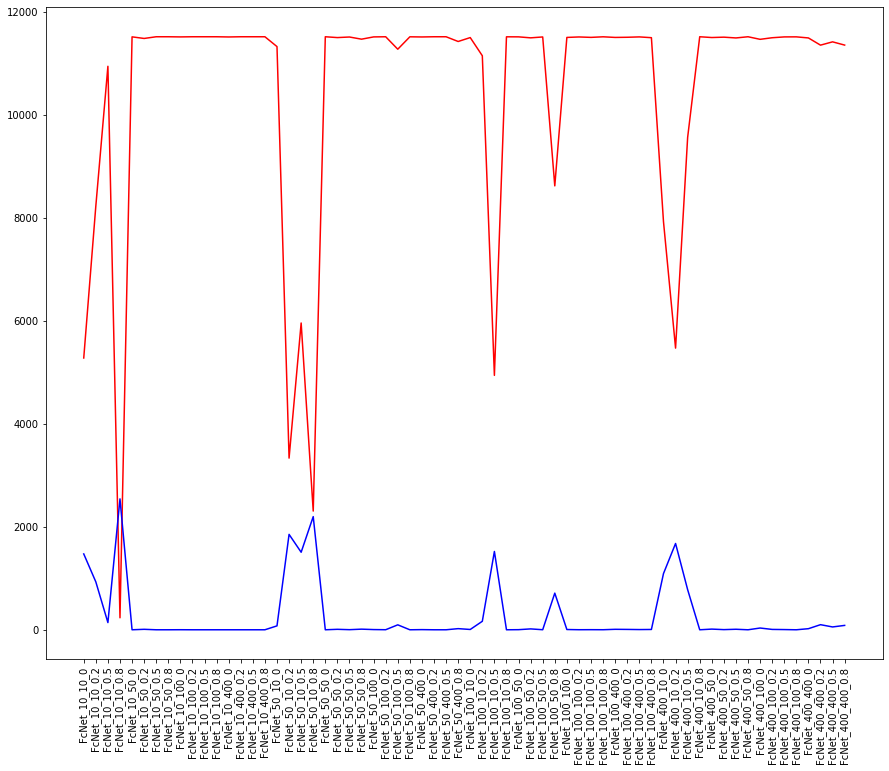

In [0]:
plt.figure(figsize=(15,12))
plt.xticks(rotation=90)
plt.plot(keys, answer_tp, 'r')
plt.plot(keys, answer_tn, 'b')

большинство классификаторов сваливается в константный классификатор, попробуем бороться с этим балансированием классов датасета

Попробуем сбалансировать классы и обучить такие же классификаторы

In [0]:
data_s1 = data[data["Loan Status"] == 0].sample(n=len(data[data["Loan Status"] == 1])) # Попробуем сбаланировать выборку, уменьшая ее размерность
data_s2 = data[data["Loan Status"] == 1]
data_s = data_s1.append(data_s2)

X = data_s.drop('Loan Status', axis = 1) 
y = data_s['Loan Status']
feature_names = X.columns
print(X.shape[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [0]:
first_layer_set = [10, 50, 100, 400]
second_layer_set = [10, 50, 100, 400]
dropout_set = [0, 0.2, 0.5, 0.8]
result_balanced = dict()

datasets = {
        'train': Dataset(x=X_train, y=y_train),
        'test':  Dataset(x=X_test, y=y_test),
        'val': Dataset(x=X_val, y=y_val)
    }

dataloaders = {
        x: torch.utils.data.DataLoader(
            datasets[x], batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
        for x in ['train', 'val', "test"]
    }

for first_layer in first_layer_set:
  for second_layer in second_layer_set:
    for dropout in dropout_set:

      model = FcNet(2, X.shape[1], first_layer, second_layer, dropout, dropout)
      model = model.to(device)
      model = model.double()
      learning_rate = 0.001
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)

      result_balanced["FcNet_"+str(first_layer)+"_"+str(second_layer)+"_"+str(dropout)]  = train_test_val(model,dataloaders,optimizer, learning_rate)

      

In [0]:
answer_acc, answer_loss = predict_classificators(result_balanced, datasets)

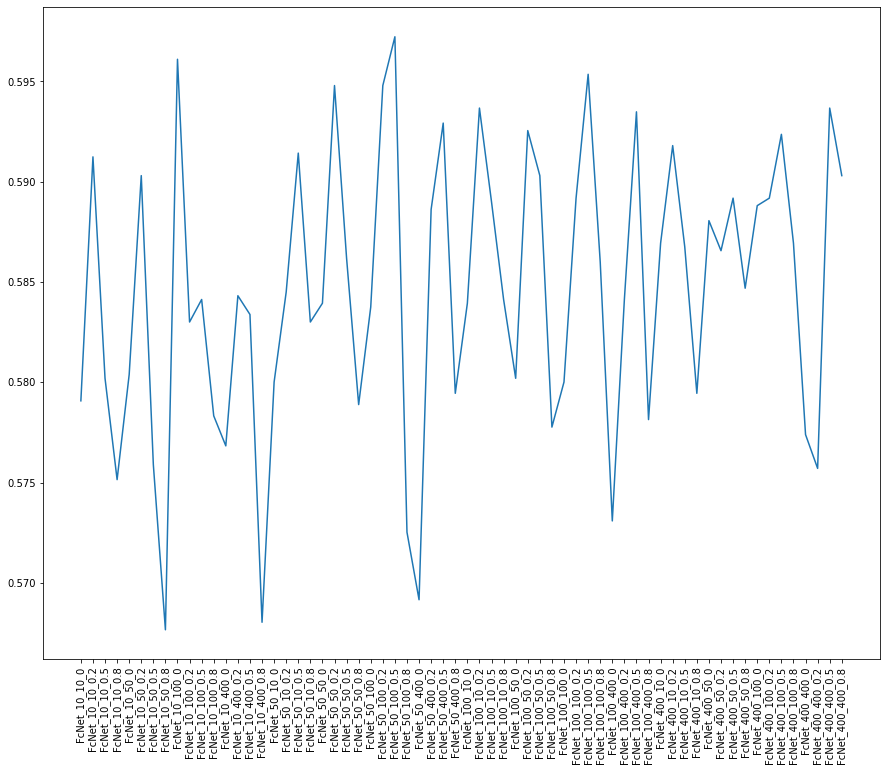

In [0]:
plt.figure(figsize=(15,12))
plt.xticks(rotation=90)
plt.plot(keys, answer_acc)

Тюнинг параметров и балансирование классов явной пользы не дали. Попробуем взять лучшую модель, когда мы обучали на полной выборке, я считаю что это FcNet_100_50_0.8, т.к. она не полностью свалилась в константный классификатор и способна верно предсказывать объекты класса, в котором представленно мало объектов.

In [0]:
first_layer_set = [100]
second_layer_set = [50]
dropout_set = [0.8]
weight_decay_set = np.logspace(-3, 2, 21)
batch_size = 100000
result_with_L2 = dict()

datasets = {
        'train': Dataset(x=X_train, y=y_train),
        'test':  Dataset(x=X_test, y=y_test),
        'val': Dataset(x=X_val, y=y_val)
    }

dataloaders = {
        x: torch.utils.data.DataLoader(
            datasets[x], batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
        for x in ['train', 'val', "test"]
    }

for first_layer in first_layer_set:
  for second_layer in second_layer_set:
    for dropout in dropout_set:
      for weight_decay in weight_decay_set:
        model = FcNet(2, X.shape[1], first_layer, second_layer, dropout, dropout)
        model = model.to(device)
        model = model.double()
        learning_rate = 0.001
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        result_with_L2["FcNet_"+str(first_layer)+"_"+str(second_layer)+"_"+str(dropout)+"_"+str(weight_decay)]  = train_test_val(model,dataloaders,optimizer, learning_rate)

      

In [0]:
answer_acc, answer_loss, answer_f1, answer_matrix, keys = predict_classificators(result_with_L2, datasets)

In [0]:
answer_tp = [i[0][0] for i in answer_matrix]
answer_tn = [i[1][1] for i in answer_matrix]

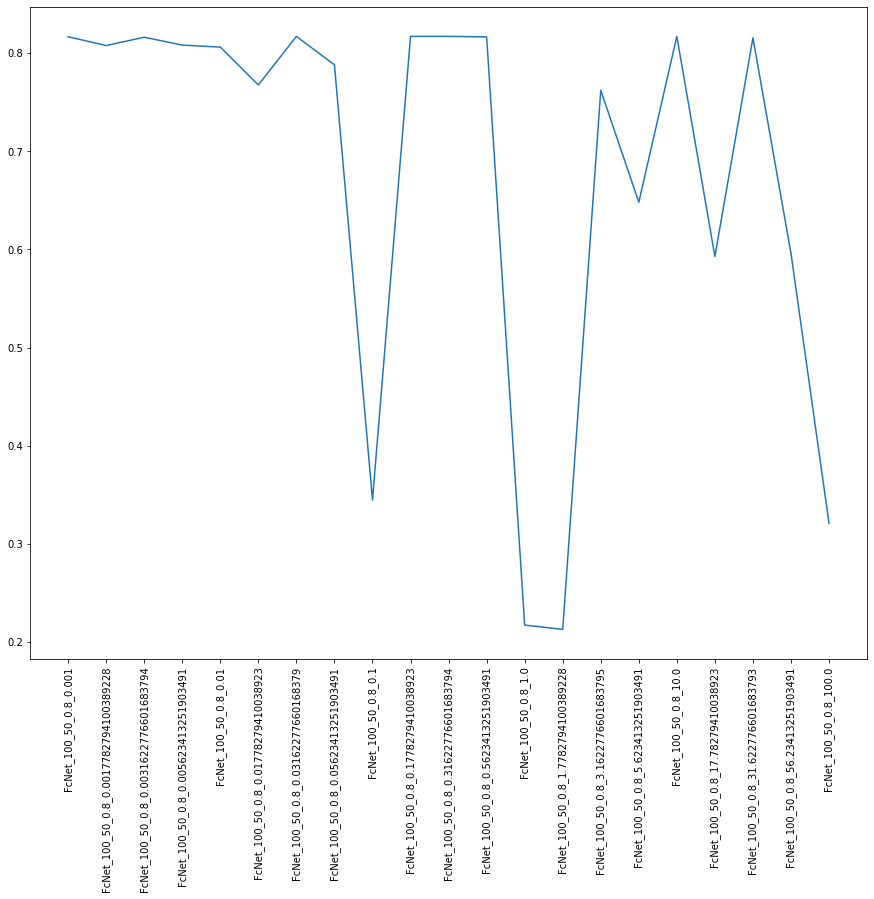

In [0]:
plt.figure(figsize=(15,12))
plt.xticks(rotation=90)
plt.plot(keys, answer_acc)

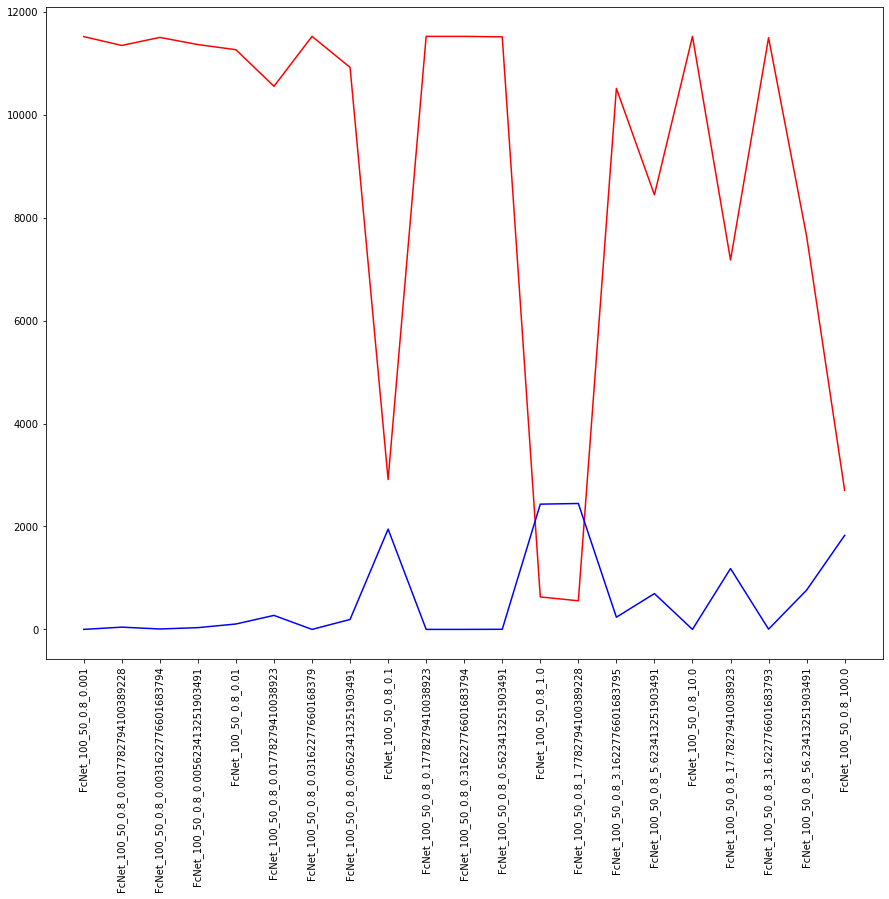

In [0]:
plt.figure(figsize=(15,12))
plt.xticks(rotation=90)
plt.plot(keys, answer_tp, 'r')
plt.plot(keys, answer_tn, 'b')

Исходя из графиков выше, увеличение шртафа для L2 лосс ухудшает точность классификаторов, в данной задаче применять его не считаю необходимым.

# Лабораторная работа: Нейросети + PCA

In [0]:
data = pd.read_csv("drive/colab/Zolotich/processed_credit_train.csv")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [0]:
X = data.drop('Loan Status', axis = 1) 
y = data['Loan Status']
feature_names = X.columns

Возьмем лучшую сеть, полученную в результате выполнения предыдущей работы - FcNet_100_50_0.8. Применим PCA разложение, возьмем ключевые компоненты, которые использовали до этого

In [0]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split

test_errors = list()
first_layer_set = [100]
second_layer_set = [50]
dropout_set = [0.8]
result = dict()
batch_size = 100000
weight_decay_set = [0]+np.logspace(-3, 2, 11).tolist()
acc_result = dict() 
for i in [2, 4, 9, 11]:
  pca = PCA(n_components=i, random_state=42)
  decomposed_data_X = pca.fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(decomposed_data_X, y, test_size = 0.3, random_state = 42)
  X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)


  datasets = {
        'train': Dataset(x=X_train, y=y_train),
        'test':  Dataset(x=X_test, y=y_test),
        'val': Dataset(x=X_val, y=y_val)
    }

  dataloaders = {
        x: torch.utils.data.DataLoader(
            datasets[x], batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
        for x in ['train', 'val', "test"]
    }

  for first_layer in first_layer_set:
    for second_layer in second_layer_set:
      for dropout in dropout_set:
        # for weight_decay in weight_decay_set:
          print("FcNet_"+str(first_layer)+"_"+str(second_layer)+"_"+str(dropout)+"_"+str(weight_decay)+"_"+str(i))
          model = FcNet(2, X_train.shape[1], first_layer, second_layer, dropout, dropout)
          model = model.to(device)
          model = model.double()
          learning_rate = 0.001
          optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)

          result["FcNet_"+str(first_layer)+"_"+str(second_layer)+"_"+str(dropout)+"_"+str(0)+"_"+str(i)]  = train_test_val(model,dataloaders,optimizer, learning_rate)
          acc_result["FcNet_"+str(first_layer)+"_"+str(second_layer)+"_"+str(dropout)+"_"+str(0)+"_"+str(i)] = predict_classificators(result["FcNet_"+str(first_layer)+"_"+str(second_layer)+"_"+str(dropout)+"_"+str(0)+"_"+str(i)], datasets)

In [0]:
acc = list()
keys = list()
answer_tp = list()
answer_tn = list()
for classificator in acc_result:
  acc.append(acc_result[classificator][0])
  keys.append(classificator)

  answer_tp.append(acc_result[classificator][3][0][0][0])
  answer_tn.append(acc_result[classificator][3][0][1][1])

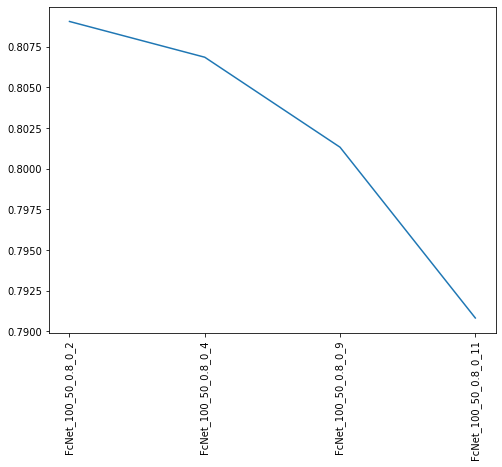

In [0]:
plt.figure(figsize=(8,6))
plt.xticks(rotation=90)
plt.plot(keys, acc)

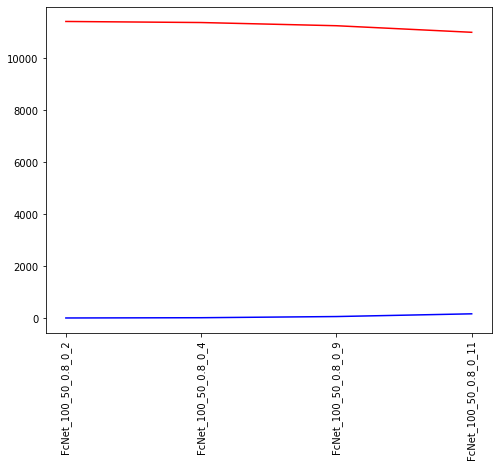

In [0]:
plt.figure(figsize=(8,6))
plt.xticks(rotation=90)
plt.plot(keys, answer_tp, 'r')
plt.plot(keys, answer_tn, 'b')

Применение PCA разложения не дает значительных улучшений в результатах. Классификатор сваливается в константный классификатор.

# Лабораторная работа: бустинг деревьев

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
data = pd.read_csv("processed_credit_train.csv")

In [6]:
data.head()

,Unnamed: 0,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,...,Purpose_Medical Bills,Purpose_Other,Purpose_major_purchase,Purpose_moving,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding,Loan Status,Term
0,0,0.795248,-0.346281,-0.224637,-1.106245,-0.141229,-1.024475,2.280922,-0.192353,-0.284364,...,0,0,0,0,0,0,0,0,0,0
1,2,-0.222213,0.922629,1.231962,0.899866,-0.469323,1.376156,2.280922,0.016758,0.113453,...,0,0,0,0,0,0,0,0,0,0
2,3,0.236738,0.129560,-0.718031,-0.811243,-0.883006,-0.424317,-0.370452,-0.108060,-0.319913,...,0,0,0,0,0,0,0,0,0,1
3,6,-0.506182,0.486441,-0.201782,-0.634502,0.201129,0.375893,2.280922,-0.509948,-0.457043,...,0,0,0,0,0,0,0,0,0,0
4,8,1.385687,-1.575536,1.679751,0.018306,0.629077,-1.424580,-0.370452,0.433673,-0.119324,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X = data.drop(['Loan Status', "Unnamed: 0"], axis = 1) 
y = data['Loan Status']
feature_names = X.columns
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [9]:
num_trees = [30,40,50,60,70,80,90,100,110,120,130,140,150,200,250,500,1000, 1500, 2000]

Задал разное количество деревьев, обучаем классификаторы.

In [11]:
rfc = []
err_test_rf = []
err_train_rf = []
oob_err = []

for i in num_trees:
  rfc.append(RandomForestClassifier(n_estimators=i, max_depth=4,
                                random_state=0, warm_start=True,oob_score=True, n_jobs=4,criterion="entropy", verbose=1))
  rfc[-1].fit(train_X, y_train) 
  y_test_predict = rfc[-1].predict(test_X)
  oob_err.append(1 - rfc[-1].oob_score_)
  err_test_rf.append(np.mean(y_test  != y_test_predict))
  err_train_rf.append(1 - rfc[-1].score(train_X, y_train))
  print(f"RF, {i} - estimators, error train - {err_train_rf[-1]}, error test - {err_test_rf[-1]}, oob error - {oob_err[-1]}")


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.1s finished


RF, 30 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


RF, 40 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


RF, 50 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


RF, 60 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.2s finished


RF, 70 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


RF, 80 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


RF, 90 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


RF, 100 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 110 out of 110 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 110 out of 110 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 110 out of 110 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


RF, 110 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


RF, 120 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


RF, 130 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


RF, 140 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


RF, 150 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


RF, 200 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    8.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.7s finished


RF, 250 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   16.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.4s finished


RF, 500 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   25.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   32.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Paral

RF, 1000 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   25.5s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:   40.0s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:   48.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Par

RF, 1500 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   25.8s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:   40.6s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:   58.0s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 2000 

RF, 2000 - estimators, error train - 0.19033659396075098, error test - 0.18702154805783952, oob error - 0.19033659396075098


[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    5.8s finished


Построим графики ошибок в зависимости от количества деревьев.

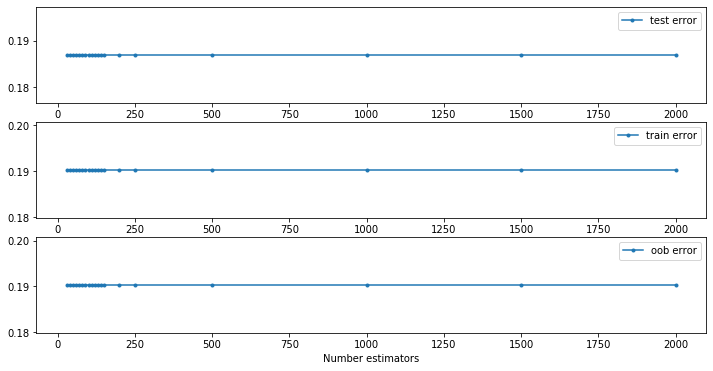

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
plt.plot(num_trees, err_test_rf, ".-", label = "test error")
plt.legend()
plt.subplot(3,1,2)
plt.plot(num_trees, err_train_rf, ".-", label = "train error")
plt.legend()
plt.subplot(3,1,3)
plt.plot(num_trees, oob_err, ".-", label = "oob error")
plt.xlabel("Number estimators")
plt.legend()
pass

Все классификаторы дают одинаковую ошибку при различном количестве деревьев. Попробуем проанализировать из за чего это происходит. Для этого посмотрим матрицы ошибок.

Рассмотрим матрицы ошибок:

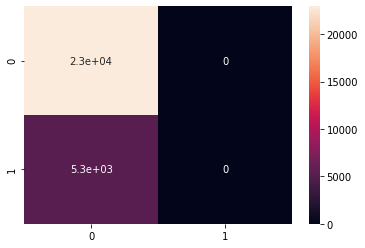

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predict)
sns.heatmap(cm, annot=True)

In [17]:
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     22939
           1       0.00      0.00      0.00      5277

    accuracy                           0.81     28216
   macro avg       0.41      0.50      0.45     28216
weighted avg       0.66      0.81      0.73     28216



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Классификаторы сваливаются в константный классификатор из за несбалансированности классов. Ради интереса посмотрим, используют ли классификаторы разные фичи.

In [0]:
def variable_importance(fit):
    importances = fit.feature_importances_
    indices = np.argsort(importances)[::-1]
    return {'importance': importances,
            'index': indices}

In [0]:
def variable_importance_plot(importance, indices, names_index):
    index = np.arange(len(names_index))

    importance_desc = sorted(importance)
    feature_space = []
    for i in range(indices.shape[0] - 1, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 10))

    # ax.set_axis_bgcolor('#fafafa')
    plt.title('Feature importances for Random Forest Model\
    \nBreast Cancer (Diagnostic)')
    plt.barh(index,
             importance_desc,
             align="center",
             color = '#875FDB')
    plt.yticks(index,
               feature_space)

    plt.ylim(-1, 30)
    plt.xlim(0, max(importance_desc) + 0.01)
    plt.xlabel('Mean Decrease in Impurity')
    plt.ylabel('Feature')

    plt.show()
    plt.close()

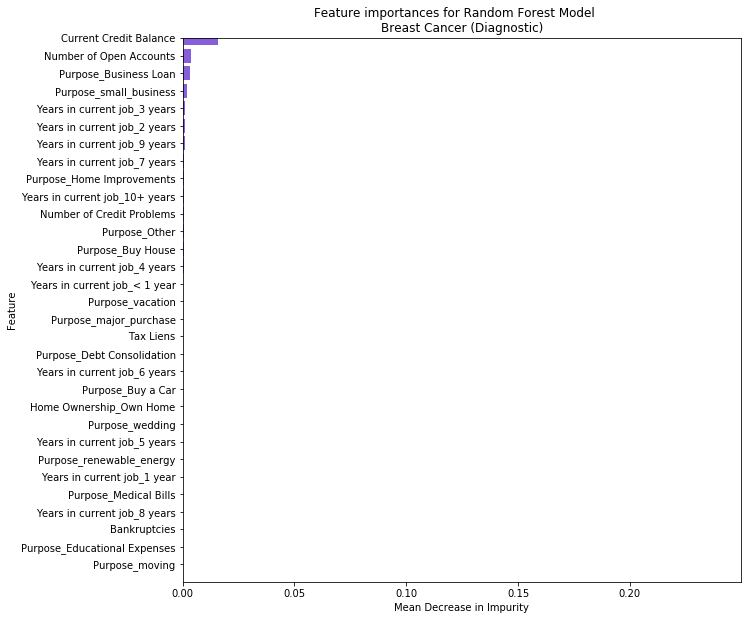

In [23]:
var_imp_rf = variable_importance(rfc[0])
importances_rf = var_imp_rf['importance']
indices_rf = var_imp_rf['index']
variable_importance_plot(importances_rf, indices_rf, feature_names)

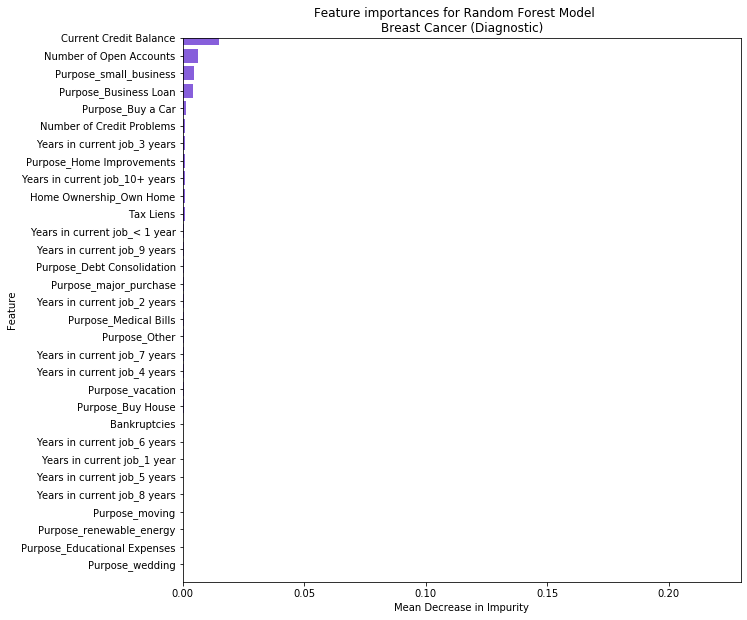

In [22]:
var_imp_rf = variable_importance(rfc[-1])
importances_rf = var_imp_rf['importance']
indices_rf = var_imp_rf['index']
variable_importance_plot(importances_rf, indices_rf, feature_names)

К удивлению классификаторы для своих предсказаний используют разные фичи, но это не дает улучшений.

 Попробуем бороться с этой проблемой, используя веса для классов в моменте обучения.

In [10]:
rfc = []
err_test_rf = []
err_train_rf = []
oob_err = []
 

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

for i in num_trees:
  rfc.append(RandomForestClassifier(n_estimators=i, max_depth=4,
                                random_state=0, warm_start=True,oob_score=True, n_jobs=4,criterion="entropy", verbose=1, class_weight={0:class_weights[0], 1:class_weights[1]}))
  rfc[-1].fit(train_X, y_train) 
  y_test_predict = rfc[-1].predict(test_X)
  oob_err.append(1 - rfc[-1].oob_score_)
  err_test_rf.append(np.mean(y_test  != y_test_predict))
  err_train_rf.append(1 - rfc[-1].score(train_X, y_train))
  print(f"RF, {i} - estimators, error train - {err_train_rf[-1]}, error test - {err_test_rf[-1]}, oob error - {oob_err[-1]}")


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished


RF, 30 - estimators, error train - 0.43584057354638794, error test - 0.43776580663453357, oob error - 0.43760252749255724


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.1s finished


RF, 40 - estimators, error train - 0.4391214533082204, error test - 0.4403884320952651, oob error - 0.44000243028130503


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


RF, 50 - estimators, error train - 0.43886323591955767, error test - 0.44095548624893677, oob error - 0.43982015918342543


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.2s finished


RF, 60 - estimators, error train - 0.4392277781153169, error test - 0.44187694924865323, oob error - 0.43962269882738925


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.1s finished


RF, 70 - estimators, error train - 0.43629625129108696, error test - 0.4374468386730933, oob error - 0.43998724102314846


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.1s finished


RF, 80 - estimators, error train - 0.4321951515887964, error test - 0.4341153955202722, oob error - 0.43555197764141196


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    0.7s finished


RF, 90 - estimators, error train - 0.43290904672215813, error test - 0.433583782251205, oob error - 0.43769366304149704


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


RF, 100 - estimators, error train - 0.43040281912631384, error test - 0.4316699744825631, oob error - 0.4338659699860259


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 110 out of 110 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 110 out of 110 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 110 out of 110 | elapsed:    0.3s finished


RF, 110 - estimators, error train - 0.4322103408469531, error test - 0.4330521689821378, oob error - 0.43600765538611097


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.9s finished


RF, 120 - estimators, error train - 0.4321040160398566, error test - 0.43347745959739153, oob error - 0.43594689835348444


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    0.3s finished


RF, 130 - estimators, error train - 0.43003827693055474, error test - 0.43170541536716756, oob error - 0.4345950543775442


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    0.7s finished


RF, 140 - estimators, error train - 0.4312686068412419, error test - 0.4336192231358095, oob error - 0.4369038216173522


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.5s finished


RF, 150 - estimators, error train - 0.4326508293334953, error test - 0.4339381910972498, oob error - 0.438027826720943


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


RF, 200 - estimators, error train - 0.429901573607145, error test - 0.4318471789055855, oob error - 0.43362294185551975


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.7s finished


RF, 250 - estimators, error train - 0.4313597423901817, error test - 0.4347533314431528, oob error - 0.4351418676711829


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.5s finished


RF, 500 - estimators, error train - 0.4308888753873261, error test - 0.4344343634817125, oob error - 0.43426089069809826


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   13.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    3.2s finished


RF, 1000 - estimators, error train - 0.42845859408226505, error test - 0.4325559965976751, oob error - 0.4311774712923021


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:   17.5s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:   20.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.0s


RF, 1500 - estimators, error train - 0.4289750288595905, error test - 0.433583782251205, oob error - 0.4315572027462179


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:   17.6s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:   25.6s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:   28.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9

RF, 2000 - estimators, error train - 0.4265751260708427, error test - 0.43145732917493623, oob error - 0.4300534661887113


[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    8.1s finished


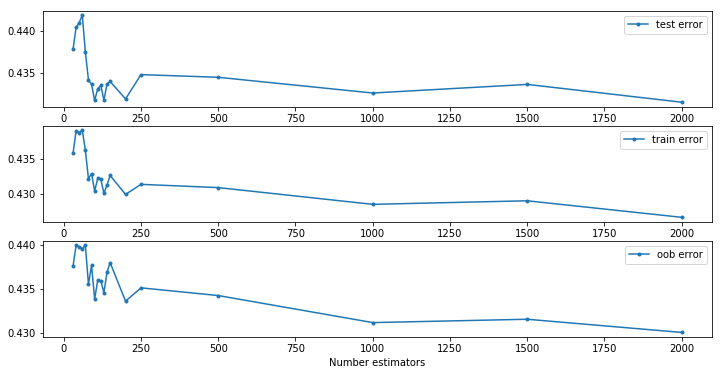

In [11]:
plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
plt.plot(num_trees, err_test_rf, ".-", label = "test error")
plt.legend()
plt.subplot(3,1,2)
plt.plot(num_trees, err_train_rf, ".-", label = "train error")
plt.legend()
plt.subplot(3,1,3)
plt.plot(num_trees, oob_err, ".-", label = "oob error")
plt.xlabel("Number estimators")
plt.legend()
pass

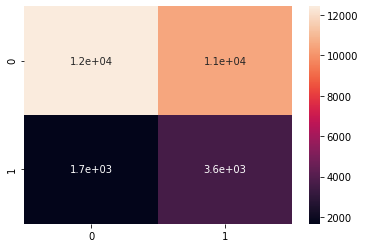

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predict)
sns.heatmap(cm, annot=True)

In [21]:
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.88      0.54      0.67     22939
           1       0.26      0.68      0.37      5277

    accuracy                           0.57     28216
   macro avg       0.57      0.61      0.52     28216
weighted avg       0.76      0.57      0.62     28216



Как видно из репорта, взвешенный классификатор дает худшие предсказания по сравнеию в не взвешенным, используя F1 метрику.

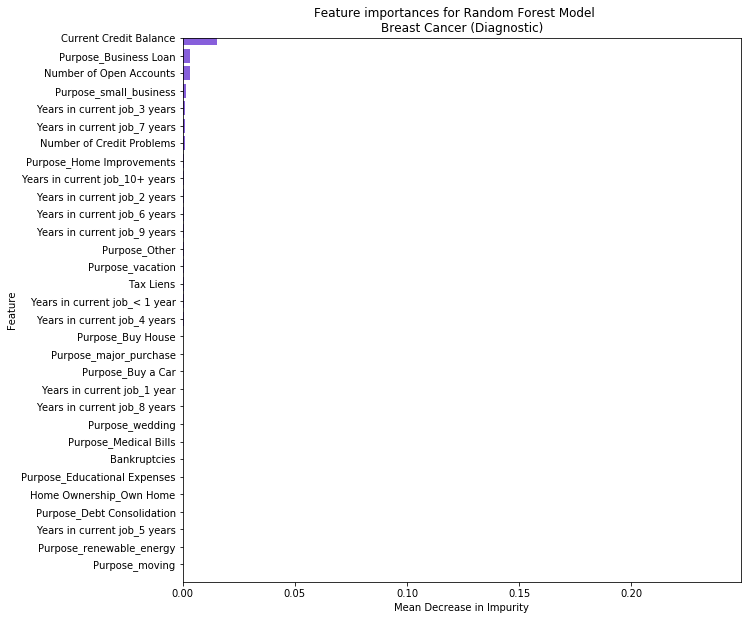

In [22]:
var_imp_rf = variable_importance(rfc[0])
importances_rf = var_imp_rf['importance']
indices_rf = var_imp_rf['index']
variable_importance_plot(importances_rf, indices_rf, feature_names)

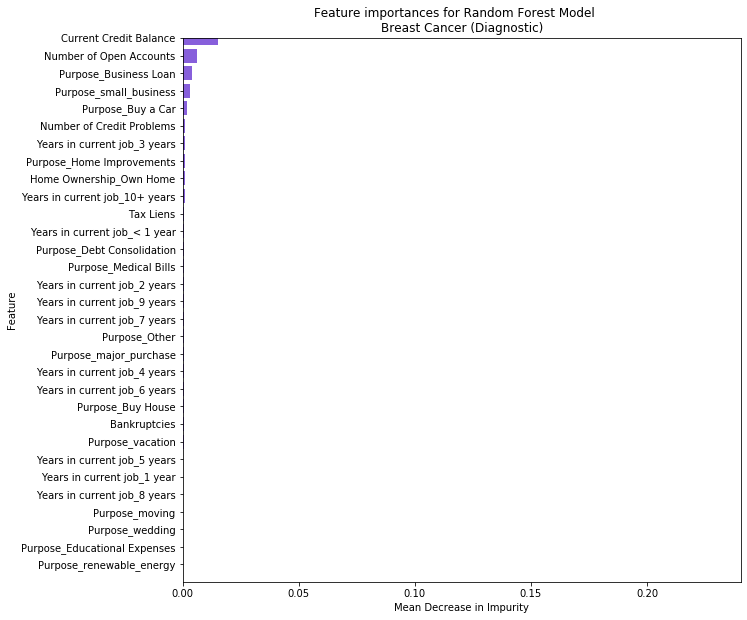

In [23]:
var_imp_rf = variable_importance(rfc[-1])
importances_rf = var_imp_rf['importance']
indices_rf = var_imp_rf['index']
variable_importance_plot(importances_rf, indices_rf, feature_names)

Для предсказаний классификаторы с весами для классов использует примерно те же фичи, что и классификаторы без весов, с соответствующим количество деревьев.

In [36]:
rfc = []
err_test_rf = []
err_train_rf = []
oob_err = []
 

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

for i in num_trees:
  rfc.append(GradientBoostingClassifier(n_estimators=i, max_depth=4,
                                random_state=0, warm_start=True, verbose=1, subsample=0.9))
  rfc[-1].fit(train_X, y_train) 
  y_test_predict = rfc[-1].predict(test_X)
  err_test_rf.append(np.mean(y_test  != y_test_predict))
  err_train_rf.append(1 - rfc[-1].score(train_X, y_train))
  print(f"RF, {i} - estimators, error train - {err_train_rf[-1]}, error test - {err_test_rf[-1]}")


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9627           0.0082            6.50s
         2           0.9573           0.0068            6.53s
         3           0.9509           0.0055            6.21s
         4           0.9432           0.0062            6.00s
         5           0.9415           0.0040            5.73s
         6           0.9341           0.0053            5.61s
         7           0.9305           0.0039            5.37s
         8           0.9261           0.0046            5.10s
         9           0.9202           0.0030            4.85s
        10           0.9188           0.0030            4.62s
        20           0.8962           0.0006            2.27s
        30           0.8870           0.0002            0.00s
RF, 30 - estimators, error train - 0.1900328087976183, error test - 0.18702154805783952
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9627           0.00

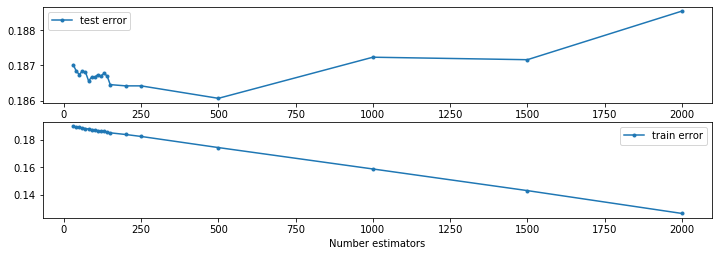

In [38]:
plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
plt.plot(num_trees, err_test_rf, ".-", label = "test error")
plt.legend()
plt.subplot(3,1,2)
plt.plot(num_trees, err_train_rf, ".-", label = "train error")
plt.legend()
plt.xlabel("Number estimators")
pass

При малом количестве наблюдается недообучение, при большем, переобучением, оптимальное значение 500.

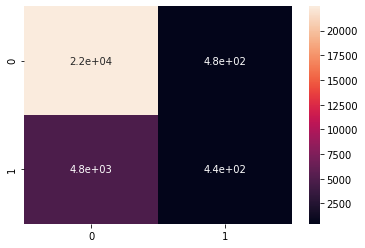

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predict)
sns.heatmap(cm, annot=True)

In [40]:
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89     22939
           1       0.48      0.08      0.14      5277

    accuracy                           0.81     28216
   macro avg       0.65      0.53      0.52     28216
weighted avg       0.76      0.81      0.75     28216



Значение F1 метрики лучше, чем у Random Foresta, однако не значительно

Лучше всего себя показал KNN, имеет минимальную ошибку на тестовой выборке, при этом не сваливается в константный классификатор:
Accuracy:
* KNN - 0.1815
* DT  - 0.25482573273384945
* SVM - 0.1783
* RF - 0.1783
* KNN with PCA - 0.1782
* FcNet - 0.1776 - (constant classification)

Как вариант, можно было попробовать сделать ансамбль Knn классификаторов, что скорее всего дало бы еще увеличение точности.

## Лабораторная работа: класстеризация

In [20]:
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight


In [8]:
data = pd.read_csv("processed_credit_train.csv")

In [9]:
data.head()

,Unnamed: 0,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,...,Purpose_Medical Bills,Purpose_Other,Purpose_major_purchase,Purpose_moving,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding,Loan Status,Term
0,0,0.795248,-0.346281,-0.224637,-1.106245,-0.141229,-1.024475,2.280922,-0.192353,-0.284364,...,0,0,0,0,0,0,0,0,0,0
1,2,-0.222213,0.922629,1.231962,0.899866,-0.469323,1.376156,2.280922,0.016758,0.113453,...,0,0,0,0,0,0,0,0,0,0
2,3,0.236738,0.129560,-0.718031,-0.811243,-0.883006,-0.424317,-0.370452,-0.108060,-0.319913,...,0,0,0,0,0,0,0,0,0,1
3,6,-0.506182,0.486441,-0.201782,-0.634502,0.201129,0.375893,2.280922,-0.509948,-0.457043,...,0,0,0,0,0,0,0,0,0,0
4,8,1.385687,-1.575536,1.679751,0.018306,0.629077,-1.424580,-0.370452,0.433673,-0.119324,...,0,0,0,0,0,0,0,0,0,0


In [10]:
X = data.drop(['Loan Status', "Unnamed: 0"], axis = 1) 
y = data['Loan Status']
feature_names = X.columns
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [11]:
model = KMeans(n_clusters=2)
model.fit(train_X)
y_test_predict = model.predict(test_X)

In [12]:
sum(y_test == y_test_predict)/len(y_test)

0.7350439466969095

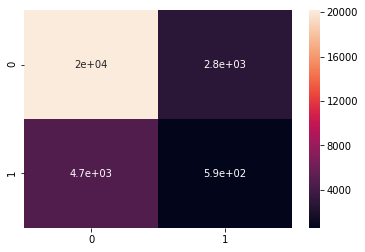

In [13]:
cm = confusion_matrix(y_test, y_test_predict)
sns.heatmap(cm, annot=True)

In [15]:
param = {"init":["random", "k-means++"],
         "max_iter":[300,400],
         "tol": [1e-3,1e-4],
         "algorithm": ["auto", "full","elkan"]}
model = KMeans(n_clusters=2)
grid = GridSearchCV(model, param_grid = param, n_jobs=2, verbose=True)
grid.fit(train_X)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  72 out of  72 | elapsed:  3.1min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'init': ['random', 'k-means++'], 'max_iter': [300, 400], 'tol': [0.001, 0.0001], 'algorithm': ['auto', 'full', 'elkan']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [18]:
y_test_predict = grid.predict(test_X)
sum(y_test != y_test_predict)/len(y_test)

0.7350439466969095

In [28]:
model = DBSCAN()
model.fit(train_X)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

In [27]:
model.labels_

array([-1, -1, -1, ..., 36, -1, -1], dtype=int64)